# Baseline Model
## Simple CNN from Scratch

This notebook trains a baseline CNN model from scratch to establish a performance baseline before using transfer learning.

**Goals:**
- Build a simple CNN architecture
- Implement training loop with validation
- Track metrics (loss, accuracy)
- Save best model checkpoint
- Visualize learning curves

In [1]:
import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

# Direct assignment
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


## 1. Load Preprocessed Data

In [2]:
with open('/Users/sujanbhattarai/deep_learning/data/data/split_info.json', 'r') as f:
    split_info = json.load(f)

class_to_idx = split_info['class_to_idx']
idx_to_class = {int(k): v for k, v in split_info['idx_to_class'].items()}
num_classes = len(class_to_idx)

print(f"Number of classes: {num_classes}")
print(f"Class mapping: {class_to_idx}")
print(f"\nDataset sizes:")
print(f"  Train: {split_info['train_size']}")
print(f"  Val:   {split_info['val_size']}")
print(f"  Test:  {split_info['test_size']}")

class_weights = np.load(
    "/Users/sujanbhattarai/deep_learning/models/class_weights.npy"
)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
print(f"\nClass weights loaded: {class_weights}")

Number of classes: 7
Class mapping: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Dataset sizes:
  Train: 6981
  Val:   1515
  Test:  1519

Class weights loaded: [0.920289   0.5659395  0.26464269 2.87752335 0.26430033 0.04362677
 2.06367836]


## 2. Recreate Dataset and DataLoaders

In [3]:
IMG_SIZE = 224
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD)
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD)
])

train_df = pd.read_csv('/Users/sujanbhattarai/deep_learning/data/data/train_split.csv')
val_df = pd.read_csv('/Users/sujanbhattarai/deep_learning/data/data/val_split.csv')
test_df = pd.read_csv('/Users/sujanbhattarai/deep_learning/data/data/test_split.csv')

data_dir = '/Users/sujanbhattarai/deep_learning/data/ham10000/'

from my_data_utils import SkinLesionDataset 
train_dataset = SkinLesionDataset(train_df, data_dir, transform=train_transform)
val_dataset = SkinLesionDataset(val_df, data_dir, transform=val_transform)
test_dataset = SkinLesionDataset(test_df, data_dir, transform=val_transform)

BATCH_SIZE = 32
NUM_WORKERS = 4

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=NUM_WORKERS, pin_memory=True if torch.cuda.is_available() else False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=True if torch.cuda.is_available() else False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True if torch.cuda.is_available() else False)

print(f"DataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")

🔍 Caching image paths to optimize speed...


Mapping Files:   0%|          | 0/6981 [00:00<?, ?it/s]

🔍 Caching image paths to optimize speed...


Mapping Files:   0%|          | 0/1515 [00:00<?, ?it/s]

🔍 Caching image paths to optimize speed...


Mapping Files:   0%|          | 0/1519 [00:00<?, ?it/s]

DataLoaders created:
  Train batches: 219
  Val batches:   48
  Test batches:  48


## 3. Define Baseline CNN Model

In [4]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(BaselineCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = BaselineCNN(num_classes=num_classes).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("="*60)
print("BASELINE CNN ARCHITECTURE")
print("="*60)
print(model)
print("\n" + "="*60)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print("="*60)

BASELINE CNN ARCHITECTURE
BaselineCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

## 4. Setup Training Configuration

In [5]:
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                                  patience=3)

print("Training Configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Weight Decay: {WEIGHT_DECAY}")
print(f"  Optimizer: Adam")
print(f"  Scheduler: ReduceLROnPlateau")
print(f"  Loss: CrossEntropyLoss with class weights")

Training Configuration:
  Epochs: 30
  Learning Rate: 0.001
  Weight Decay: 0.0001
  Optimizer: Adam
  Scheduler: ReduceLROnPlateau
  Loss: CrossEntropyLoss with class weights


## 5. Training and Validation Functions

In [6]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': loss.item(), 'acc': 100. * correct / total})
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation', leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({'loss': loss.item(), 'acc': 100. * correct / total})
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

print("✅ Training and validation functions defined")

✅ Training and validation functions defined


## 6. Train the Model

In [7]:
####### Sanity Check: Overfitting on a small batch#
# Grab 10 images and labels once
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Get one single real batch
data_iter = iter(train_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

print(f"Starting overfit test on {len(labels)} images...")
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        _, preds = outputs.max(1)
        acc = 100. * preds.eq(labels).sum().item() / labels.size(0)
        print(f"Epoch {epoch} | Loss: {loss.item():.4f} | Acc: {acc:.2f}%")

Starting overfit test on 32 images...
Epoch 0 | Loss: 1.9372 | Acc: 15.62%
Epoch 10 | Loss: 1.0390 | Acc: 68.75%
Epoch 20 | Loss: 0.4687 | Acc: 84.38%
Epoch 30 | Loss: 0.2443 | Acc: 93.75%
Epoch 40 | Loss: 0.1834 | Acc: 93.75%
Epoch 50 | Loss: 0.0491 | Acc: 100.00%
Epoch 60 | Loss: 0.0179 | Acc: 100.00%
Epoch 70 | Loss: 0.0110 | Acc: 100.00%
Epoch 80 | Loss: 0.0037 | Acc: 100.00%
Epoch 90 | Loss: 0.0030 | Acc: 100.00%


In [8]:
def run_training():
    # Ensure the directory exists
    os.makedirs('models', exist_ok=True)
    
    checkpoint_path = 'models/baseline_checkpoint_latest.pth'
    start_epoch = 0
    # Initialize history here
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0

    # Load checkpoint if it exists
    if os.path.exists(checkpoint_path):
        print(f"--- Resuming from checkpoint: {checkpoint_path} ---")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_val_acc = checkpoint.get('best_val_acc', 0.0)
        history = checkpoint.get('history', history)

    for epoch in range(start_epoch, NUM_EPOCHS):
        epoch_start = time.time()
        
        # Training and Validation steps
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        if scheduler:
            scheduler.step(val_loss)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Save latest progress
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'history': history
        }, checkpoint_path)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'val_acc': val_acc,
            }, 'models/baseline_cnn_best.pth')
            print(f"  ✅ Best model saved! (Val Acc: {val_acc:.2f}%)")

        epoch_time = time.time() - epoch_start
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - {epoch_time:.2f}s")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
        
    return history # CRITICAL: This makes the data accessible outside

In [9]:
# uncomment below to run training directly
# --- THE CRITICAL PROTECTIVE GUARD ---
history = run_training()
best_val_acc = max(history['val_acc'])

--- Resuming from checkpoint: models/baseline_checkpoint_latest.pth ---


## 7. Visualize Training History

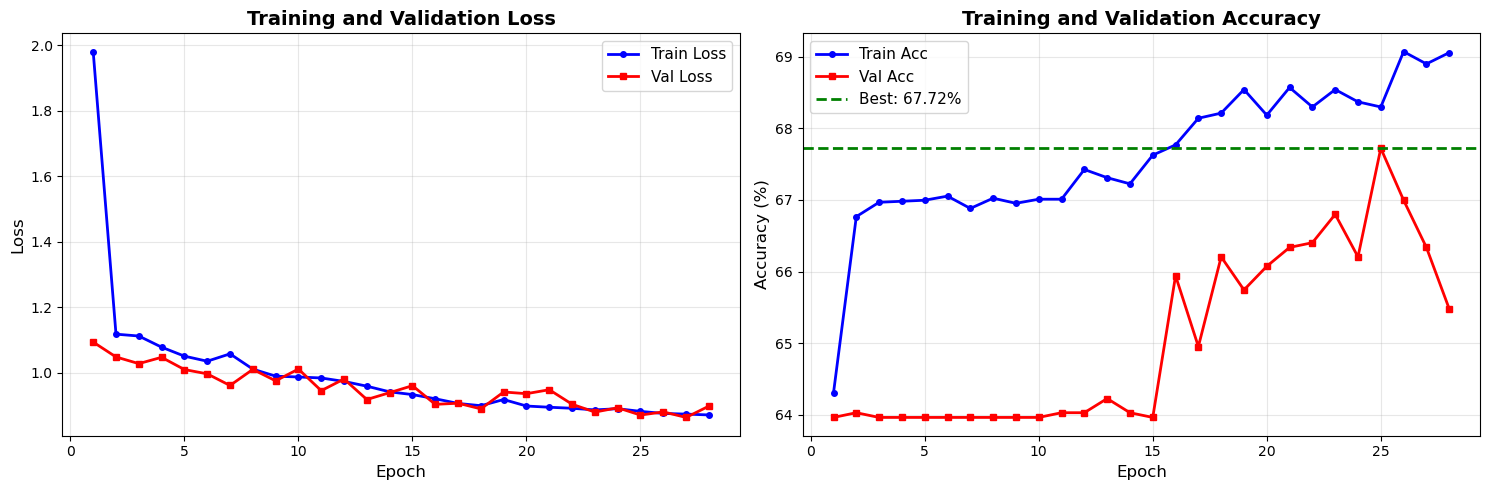

✅ Training curves saved


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(history['train_loss']) + 1)

axes[0].plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=4)
axes[0].plot(epochs, history['val_loss'], 'r-s', label='Val Loss', linewidth=2, markersize=4)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

axes[1].plot(epochs, history['train_acc'], 'b-o', label='Train Acc', linewidth=2, markersize=4)
axes[1].plot(epochs, history['val_acc'], 'r-s', label='Val Acc', linewidth=2, markersize=4)
axes[1].axhline(y=best_val_acc, color='green', linestyle='--', linewidth=2, label=f'Best: {best_val_acc:.2f}%')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('results/baseline_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Training curves saved")

## 8. Evaluate on Test Set

In [11]:
checkpoint = torch.load('models/baseline_cnn_best.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']}")
print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%\n")

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing'):
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

test_acc = 100. * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"\nTest Accuracy: {test_acc:.2f}%")

Loaded best model from epoch 27
Best validation accuracy: 67.72%



Testing: 100%|██████████| 48/48 [00:27<00:00,  1.74it/s]


Test Accuracy: 72.02%


## 9. Confusion Matrix

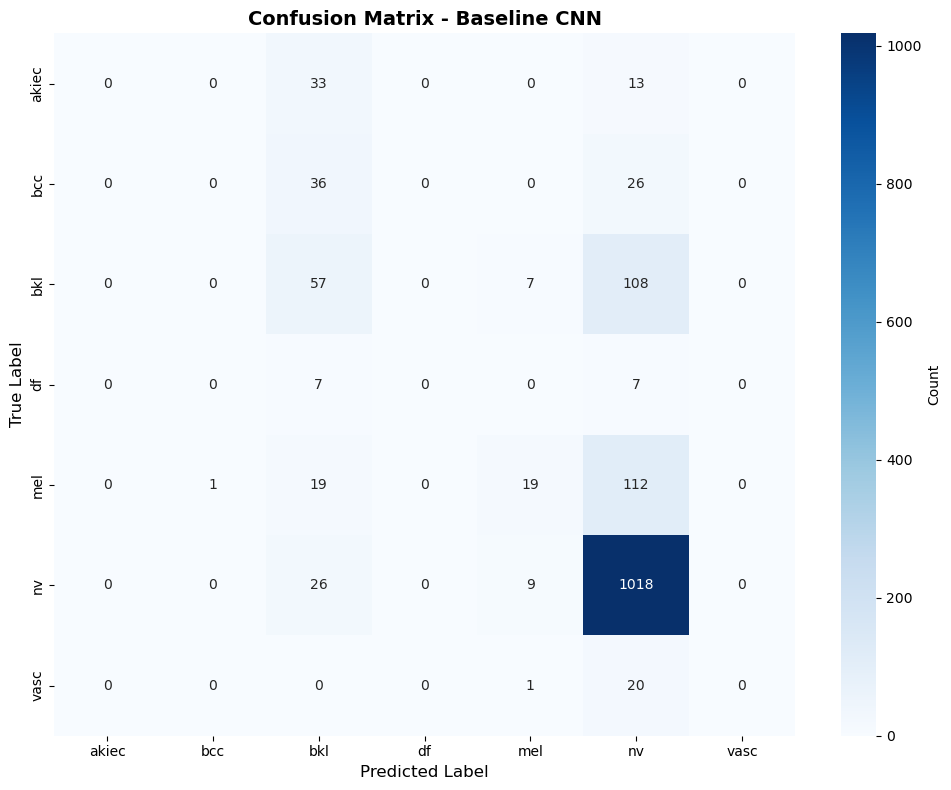

✅ Confusion matrix saved


In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[idx_to_class[i] for i in range(num_classes)],
            yticklabels=[idx_to_class[i] for i in range(num_classes)],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Baseline CNN', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('results/baseline_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Confusion matrix saved")

## 10. Classification Report

In [13]:
class_names_list = [idx_to_class[i] for i in range(num_classes)]
report = classification_report(all_labels, all_preds, target_names=class_names_list, digits=4)

print("="*70)
print("CLASSIFICATION REPORT - BASELINE CNN")
print("="*70)
print(report)
print("="*70)

with open('results/baseline_classification_report.txt', 'w') as f:
    f.write("CLASSIFICATION REPORT - BASELINE CNN\n")
    f.write("="*70 + "\n")
    f.write(report)

print("\n✅ Classification report saved")

CLASSIFICATION REPORT - BASELINE CNN
              precision    recall  f1-score   support

       akiec     0.0000    0.0000    0.0000        46
         bcc     0.0000    0.0000    0.0000        62
         bkl     0.3202    0.3314    0.3257       172
          df     0.0000    0.0000    0.0000        14
         mel     0.5278    0.1258    0.2032       151
          nv     0.7807    0.9668    0.8638      1053
        vasc     0.0000    0.0000    0.0000        21

    accuracy                         0.7202      1519
   macro avg     0.2327    0.2034    0.1990      1519
weighted avg     0.6299    0.7202    0.6559      1519


✅ Classification report saved


## 11. Summary & Key Insights

In [14]:
with open('results/baseline_training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

print("="*70)
print("BASELINE MODEL SUMMARY")
print("="*70)

print("\nMODEL ARCHITECTURE:")
print(f"  Total Parameters: {total_params:,}")
print(f"  Architecture: 4 Conv Blocks + 2 FC Layers")
print(f"  Input Size: {IMG_SIZE}x{IMG_SIZE}x3")
print(f"  Output Classes: {num_classes}")

print("\nTRAINING CONFIGURATION:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Optimizer: Adam")
print(f"  Loss: Weighted CrossEntropy")

print("\nRESULTS:")
print(f"  Best Val Accuracy: {best_val_acc:.2f}%")
print(f"  Final Test Accuracy: {test_acc:.2f}%")

print("\nKEY OBSERVATIONS:")
print("  ✓ Baseline model trained from scratch")
print("  ✓ Class weights used to handle imbalance")
print("  ✓ Data augmentation applied")
print("  ✓ Learning rate scheduling implemented")

print("\nNEXT STEPS:")
print("  → Notebook 4: Transfer Learning (ResNet, EfficientNet)")
print("  → Expected improvement: 10-15% accuracy boost")
print("  → Pre-trained ImageNet weights will help significantly")

print("\n" + "="*70)
print("BASELINE MODEL COMPLETE!")
print("="*70)

BASELINE MODEL SUMMARY

MODEL ARCHITECTURE:
  Total Parameters: 26,868,391
  Architecture: 4 Conv Blocks + 2 FC Layers
  Input Size: 224x224x3
  Output Classes: 7

TRAINING CONFIGURATION:
  Epochs: 30
  Batch Size: 32
  Learning Rate: 0.001
  Optimizer: Adam
  Loss: Weighted CrossEntropy

RESULTS:
  Best Val Accuracy: 67.72%
  Final Test Accuracy: 72.02%

KEY OBSERVATIONS:
  ✓ Baseline model trained from scratch
  ✓ Class weights used to handle imbalance
  ✓ Data augmentation applied
  ✓ Learning rate scheduling implemented

NEXT STEPS:
  → Notebook 4: Transfer Learning (ResNet, EfficientNet)
  → Expected improvement: 10-15% accuracy boost
  → Pre-trained ImageNet weights will help significantly

BASELINE MODEL COMPLETE!
